In [1]:
import sys

from kuramoto_sim import kuramoto_network
from izhi2019_wrapper import IzhiCell
import matplotlib.pyplot as plt
from utils import *
import numpy as np

%load_ext autoreload
%autoreload 2

%matplotlib qt

print('...done')

...done


In [103]:
# Simulation A has high variance in natural frequencies

random = np.random.RandomState(seed=100)
noscillators = 10
scaling = 0.01
coupling_A   = random.uniform(scaling*0.01, scaling*0.05, size=(noscillators, noscillators))
for i in range(noscillators):
    coupling_A[i,i] = 0.0
frequencies_A = random.normal(20.,5., size=(noscillators,))
net_A = kuramoto_network(noscillators, frequencies_A, coupling_A, init_phases=None, seed=0)
phases_A, mean_phase_A, synchrony_A, times_A = net_A.simulate(6000., 60.)
angles_A     = phase_to_angle(phases_A.T, times_A[1] - times_A[0])
amplitudes_A = phase_to_amplitude(phases_A.T, frequencies_A, times_A)
print('done...')

done...


In [104]:
# Sum oscillators
sum_A = np.sum(amplitudes_A, axis=1)
avg_synchrony = np.mean(synchrony_A)
print('..done')

..done


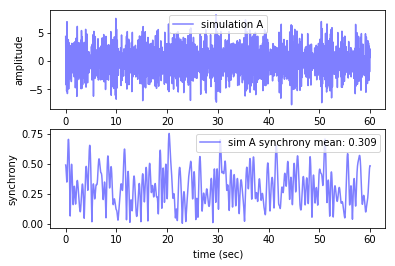

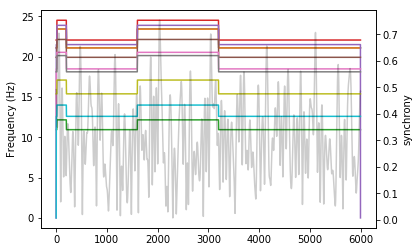

In [105]:
# Plot sum of oscillators and synchronization
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(times_A, sum_A, label='simulation A', c='b', alpha=0.5)
ax1.legend()

ax2.plot(times_A, synchrony_A, label='sim A synchrony mean: %0.3f' % avg_synchrony, c='b', alpha=0.5)
ax2.legend()

ax1.set_ylabel('amplitude')

ax2.set_ylabel('synchrony')
ax2.set_xlabel('time (sec)')

fig, (ax1) = plt.subplots(1,1)
ax1.plot(angles_A.T)
ax11 = ax1.twinx()
ax11.plot(synchrony_A, c='black', alpha=0.2)


ax1.set_ylabel('Frequency (Hz)')
ax11.set_ylabel('synchrony')

plt.show()

In [106]:
# run simulations from parameter set A on pyramidal cell neurons

soma_v_vecs_A, t_vecs_A = [], []
simulation_time_idx_A = np.where(times_A < 2.)[0]
simulation_times_A    = times_A[simulation_time_idx_A]
sim_cells_A = [IzhiCell() for _ in xrange(noscillators)]
for i in xrange(noscillators):
    print(i)
    soma_v_vec_A, t_vec_A = run_neuron_simulation(sim_cells_A[i], amplitudes_A[simulation_time_idx_A,i], simulation_times_A * 1000.)
    soma_v_vecs_A.append(soma_v_vec_A)
    t_vecs_A.append(t_vec_A)
print('...done')


0
Changed dt
1
Changed dt
2
Changed dt
3
Changed dt
4
Changed dt
5
Changed dt
6
Changed dt
7
Changed dt
8
Changed dt
9
Changed dt
...done


In [107]:
soma_voltages_A  = np.asarray(soma_v_vecs_A)
neuron_times_A   = np.asarray(t_vecs_A)

spike_times_A, spike_lst_A = extract_spikes(soma_voltages_A, neuron_times_A)

synchrony_A = np.asarray(synchrony_A)
synchrony_A_abridged = synchrony_A[simulation_time_idx_A]

chunk = 50 # ms
binned_network_activity_A, binned_times_A = bin_activity(neuron_times_A, spike_lst_A, noscillators, chunk=chunk)
    
activity_A_mean, activity_A_std = np.mean(binned_network_activity_A), np.std(binned_network_activity_A)

print('..done')


..done


In [108]:
network_activation_A = get_PSTH(binned_network_activity_A, noscillators, chunk/1000., filt=True)
t = 2000
ISI_A_lst, cv_A_lst = [], []
for i in xrange(noscillators):
    ISI_A_lst.append(get_ISI(spike_times_A[i]))
    cv_A_lst.append(get_CV(spike_times_A[i]))
   
    
ifr_A = []
for i in xrange(noscillators):
    ifr_A.append(get_instantaneous_FR(spike_times_A[i], 0.025, t_start=0., t_stop=t))
    
print('..done')

..done


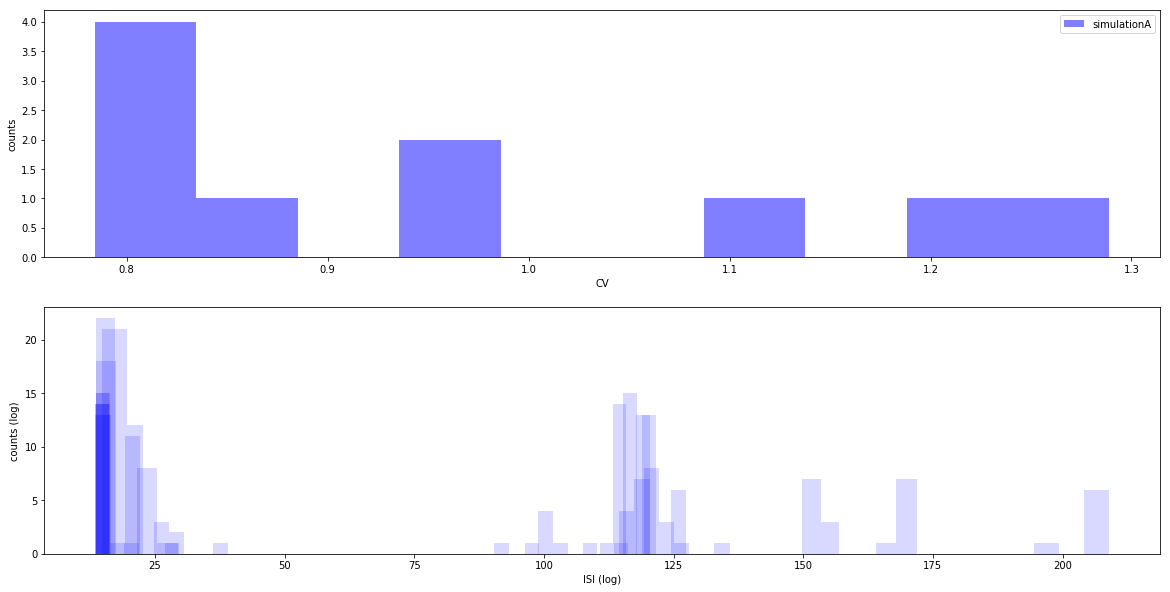

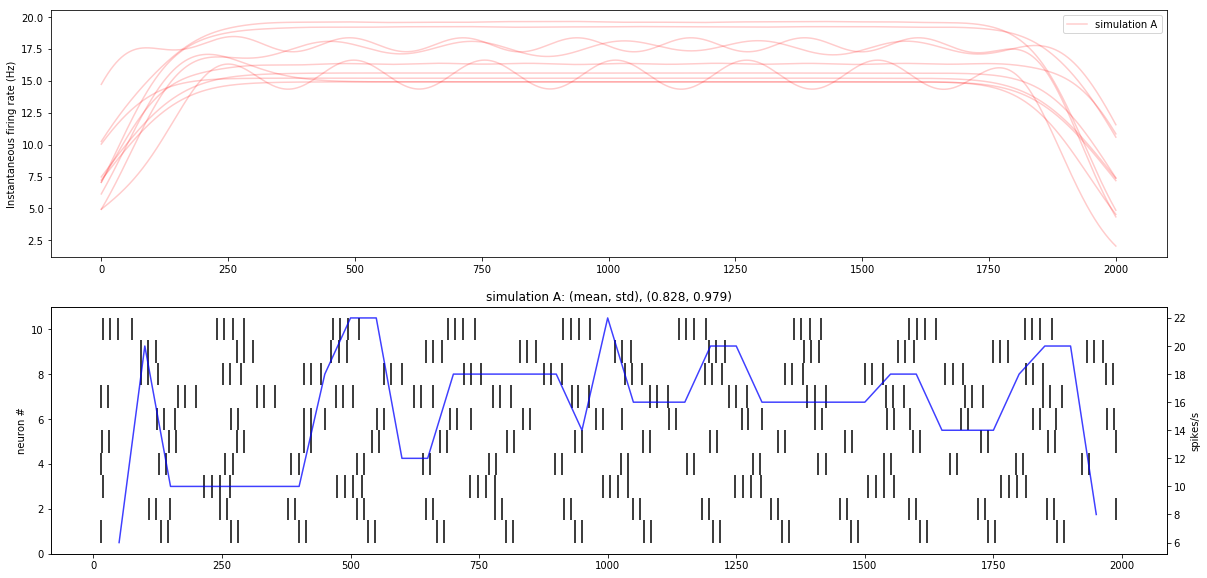

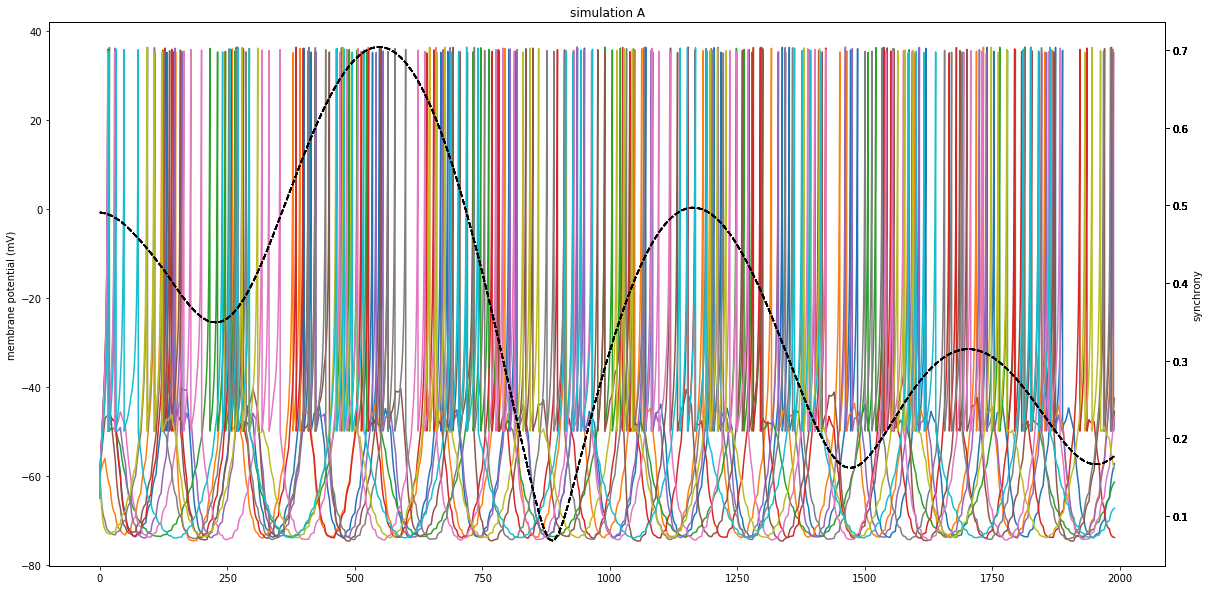

In [214]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))


ax1.hist(cv_A_lst, color='b', alpha=0.5, label='simulationA')
ax1.legend()
ax1.set_xlabel('CV')
ax1.set_ylabel('counts')

for i in xrange(noscillators):
    ax2.hist(ISI_A_lst[i], bins=40, color='b', alpha=0.15)
ax2.set_xlabel('ISI (log)')
ax2.set_ylabel('counts (log)')
plt.show()


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
ifr_times = np.arange(0., t, 0.025)
for i in xrange(noscillators):
    if i == noscillators - 1:
        ax1.plot(ifr_times, ifr_A[i], color='r', alpha=0.2, label='simulation A')
    else:
        ax1.plot(ifr_times, ifr_A[i], color='r', alpha=0.2)
ax1.legend()
ax1.set_ylabel('Instantaneous firing rate (Hz)')

for i in xrange(len(spike_times_A)):
    ax2.vlines(spike_times_A[i], i + 0.5, i + 1.5)
    ax2.set_ylabel('neuron #')
    ax2.set_title('simulation A: (mean, std), (%0.3f, %0.3f)' % (activity_A_mean, activity_A_std))
ax22 = ax2.twinx()
ax22.plot(binned_times_A[0], network_activation_A, c='b', alpha=0.75)
ax22.set_ylabel('spikes/s')

fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
for i in xrange(len(soma_voltages_A)):
    ax1.plot(neuron_times_A[i], soma_voltages_A[i,:])
    ax11 = ax1.twinx()
    ax11.plot(simulation_times_A*1000., synchrony_A_abridged, 'black', linestyle='--')
    ax1.set_title('simulation A')
    
ax1.set_ylabel('membrane potential (mV)')
ax11.set_ylabel('synchrony')

plt.xlabel('time (msec)')
plt.show()


networks set up


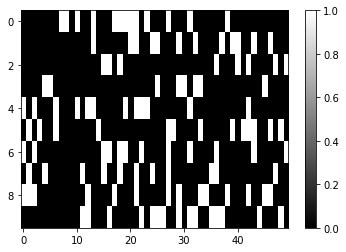

In [207]:
from izhi_network import IzhiNetwork 

nneurons = 50
chunk = 50
delay = 2000.
rate  = 40. # 40 Hz stimulation
izhi_net_A = IzhiNetwork(spike_times_A, nneurons, delay=delay, rate=rate, cell_type='RS', stim_weight=0.025, p_connection=0.25, stim_delay=1.)
print('networks set up')


connA = izhi_net_A.connections

plt.figure()
plt.imshow(connA, cmap='gray', aspect='auto')
plt.colorbar()
plt.show()

In [209]:
net_A_voltages, net_A_times = izhi_net_A.simulate_izhi_network(tstop=2000., verbose=False)
print('simulation A done')


simulation A done


In [210]:
tA = np.tile(net_A_times, (nneurons,1))
spike_times_netA, spike_lst_netA = extract_spikes(net_A_voltages, tA)
binned_network_activity_netA, binned_times_netA = bin_activity(tA, spike_lst_netA, nneurons, chunk=chunk)

print('done..')

done..


In [211]:
network_activation_netA = get_PSTH(binned_network_activity_netA, nneurons, chunk/1000., filt=True)
activity_netA_mean, activity_netA_std = np.mean(binned_network_activity_netA), np.std(binned_network_activity_netA)

print('done...')

done...


Using matplotlib backend: Qt4Agg


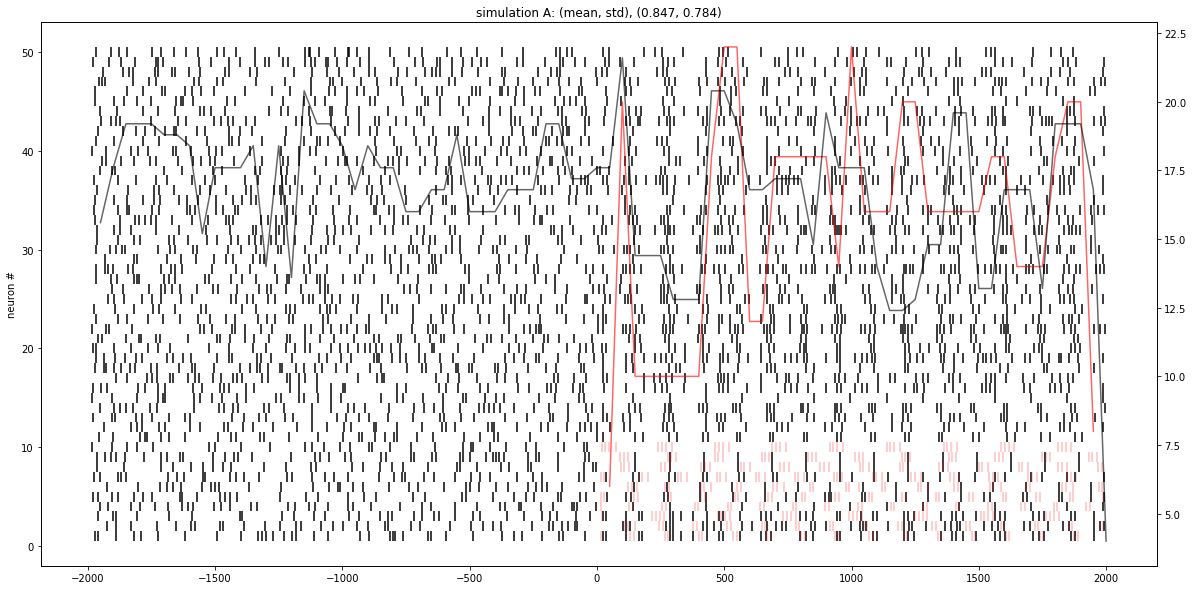

In [212]:
%matplotlib auto
fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
for i in xrange(len(spike_times_netA)):
    ax1.vlines(spike_times_netA[i]-delay, i + 0.5, i + 1.5,)
    ax1.set_ylabel('neuron #')
    
ax11 = ax1.twinx()
ax11.plot(binned_times_A[0], network_activation_A, c='r', alpha=0.60)
ax11.plot(np.subtract(binned_times_netA[0],delay), network_activation_netA, c='black', alpha=0.60)

ax1.set_title('simulation A: (mean, std), (%0.3f, %0.3f)' % (activity_netA_mean, activity_netA_std))

for i in xrange(len(spike_times_A)):
    ax1.vlines(spike_times_A[i], i + 0.5, i + 1.5, 'r', alpha=0.25)


Text(0,0.5,'count')

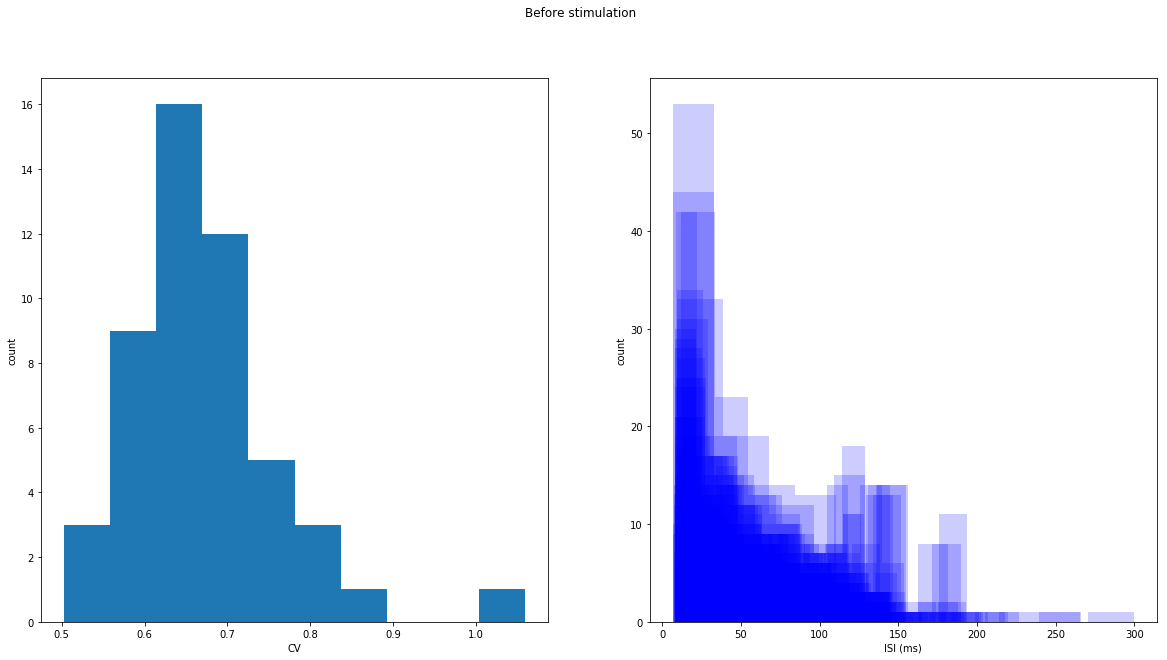

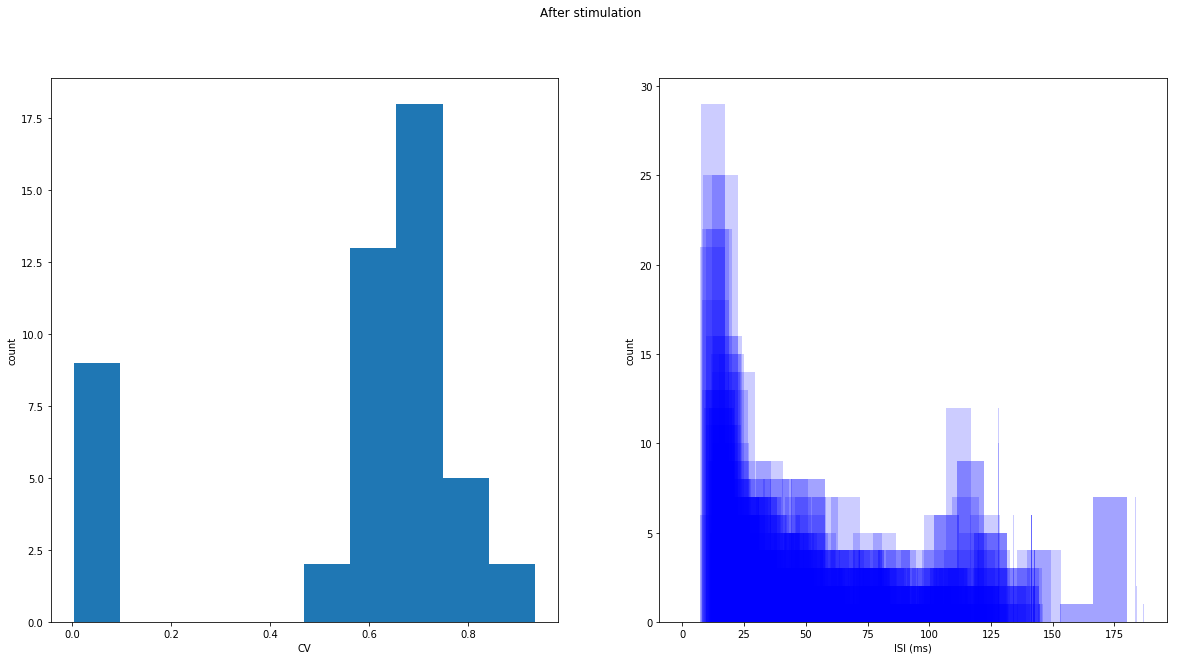

In [213]:
import math

prestim_spikes = spike_times_netA
ISI_prestim_lst, cv_prestim_lst = [], []

for i in xrange(nneurons):
    curr_spikes = prestim_spikes[i]
    curr_spikes = curr_spikes[curr_spikes < delay]
    ISI_prestim_lst.append(get_ISI(prestim_spikes[i]))
    cv_prestim_lst.append(get_CV(prestim_spikes[i]))

    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
fig.suptitle('Before stimulation')
ax1.hist(cv_prestim_lst)
for i in xrange(nneurons):
    ax2.hist(ISI_prestim_lst[i], color='b', alpha=0.2)
#ax2.set_yscale('log')

ax1.set_xlabel('CV')
ax1.set_ylabel('count')

ax2.set_xlabel('ISI (ms)')
ax2.set_ylabel('count')


poststim_spikes = spike_times_netA
ISI_poststim_lst, cv_poststim_lst = [], []
for i in xrange(nneurons):
    curr_spikes = poststim_spikes[i]
    curr_spikes = curr_spikes[curr_spikes > delay + 50.]
    curr_ISI = get_ISI(curr_spikes)
    curr_CV  = get_CV(curr_spikes)
    ISI_poststim_lst.append(curr_ISI)
    if not math.isnan(curr_CV):
        cv_poststim_lst.append(curr_CV)

# for i in xrange(nneurons):
#     print(np.mean(ISI_poststim_lst[i]), np.std(ISI_poststim_lst[i]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
fig.suptitle('After stimulation')
ax1.hist(cv_poststim_lst)
for i in xrange(nneurons):
    ax2.hist(ISI_poststim_lst[i], color='b', alpha=0.2)
#ax2.set_yscale('log')

ax1.set_xlabel('CV')
ax1.set_ylabel('count')

ax2.set_xlabel('ISI (ms)')
ax2.set_ylabel('count')
